# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов. Используются следующие инструменты:
- частотный анализ 
- таблицы сопряжённости.

## 1. Обзор данных

In [1]:
import pandas as pd
from IPython.display import display
! pip install missingno
import missingno as msno
from pymystem3 import Mystem
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
data = pd.read_csv('data.csv')
display(data)
data.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


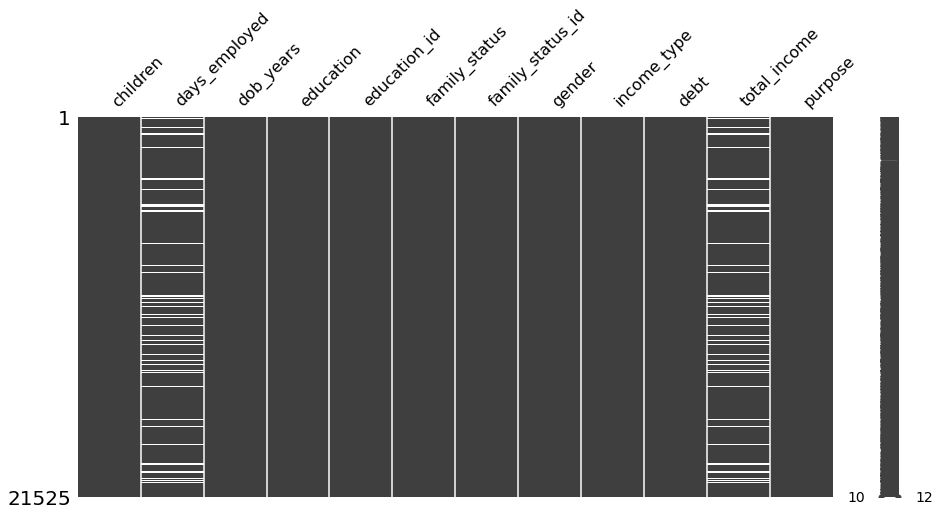

In [3]:
msno.matrix(data, figsize=(15,7))

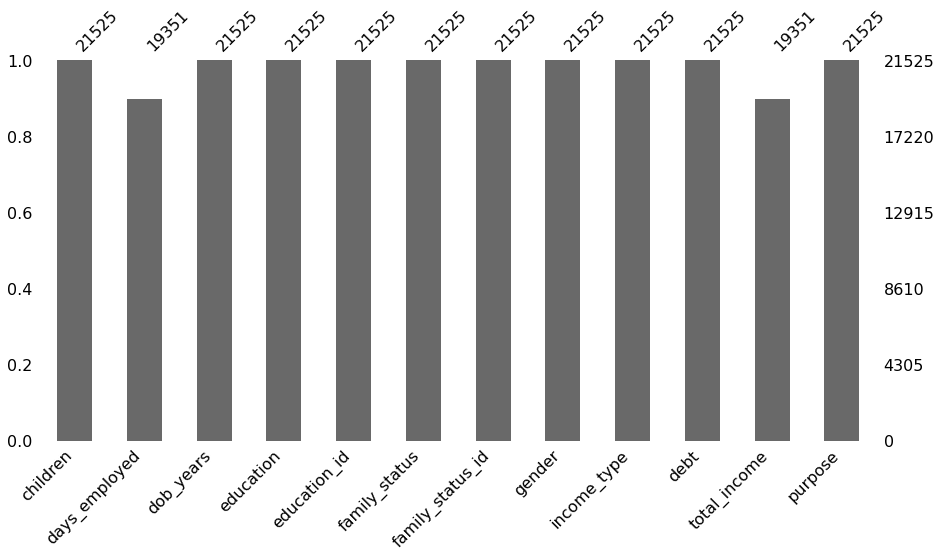

In [4]:
msno.bar(data, figsize=(15,7))

**Вывод**

Наша база данных содержит 12 столбцов и 21 525 строк. Для анализа мы воспользуемся в основном переменными семейного положения (family_status, family_status_id), количества детей (children) и переменной факта погашения кредита в срок (debt). Также для подтверждения дополнительных гипотез мы будем работать с переменными дохода (income_type, total_income) и цели кредита (purpose). Сразу обратим внимание на пропуски в переменных занятости и дохода, которые происходят синхронно. Пока можно предположить, что это безработные или пенсионеры.

## 2. Предобработка данных

### Обработка пропусков

Проверим корректность данных в двух переменных семейного положения, построив сводную таблицу по ним.

In [5]:
data_pivot_family = data.pivot_table(index=['family_status'], columns='family_status_id', values='debt', aggfunc='count')
print(data_pivot_family.head(10))
data_pivot_family.head(10).sum().sum()


family_status_id             0       1      2       3       4
family_status                                                
Не женат / не замужем      NaN     NaN    NaN     NaN  2813.0
в разводе                  NaN     NaN    NaN  1195.0     NaN
вдовец / вдова             NaN     NaN  960.0     NaN     NaN
гражданский брак           NaN  4177.0    NaN     NaN     NaN
женат / замужем        12380.0     NaN    NaN     NaN     NaN


21525.0

Переменная заполнена корректно. Каждой категории family_status соответствует только одна категория family_status_id. Уровни (значения) переменной достаточно наполнены для статистического анализа. Пропусков нет ни в одной, ни в другой переменной.

Проверим корректность заполнения переменой количества детей, проанализировав частоту встречи каждого значения.

In [6]:
print(data['children'].value_counts())
data['children'].isnull().sum()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


0

В данных нет пропусков, однако есть "артефакты" - значения "-1" и "20", причём встречающиеся не единожды. В масштабе общего массива это 0,57% строк. Посмотрим, сколько из них приходится на на нашу основную зависимую переменную наличия просрочки по кредитам.

In [7]:
data_children_artefacts = data.loc[((data['children'] == 20) | (data['children'] == -1)), ['debt']]
print(data_children_artefacts.sum())
print(data['debt'].sum())

debt    9
dtype: int64
1741


Итоговая модель будет основываться на отличиях 1 741 случая от всего массива, поэтому эти случаи наиболее важны. Среди них также 0,51% строк с неверными зчениями количества детей, что незначительно. У нас нет информации о причинах возникновения таких значений переменной, скорее всего, ошибка вызвана ручным вводом, а восстановить данные о количестве детей по другим столбцам таблицы не представляется возможным. Поэтому примем решение удалить строки с артефактами в переменной children.

In [8]:
data = data.loc[(data['children'] <= 5) & (data['children'] >= 0)]
data.reset_index(drop=True, inplace=True)
print(data['children'].value_counts())

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64


Проверим корректность заполнения переменой невозврата кредита, проанализировав частоту встречи каждого значения и посчитаем пропуски.

In [9]:
print(data['debt'].value_counts())
data['debt'].isnull().sum()

0    19670
1     1732
Name: debt, dtype: int64


0

У переменной нет пропущенных значений и артефактов. Посмотрим на переменную дохода:

In [10]:
print(round(data['total_income'].mean()))
print(round(data['total_income'].median()))
print(round(data['total_income'].min()))
print(round(data['total_income'].max()))

data['total_income'].isnull().sum()

167449
145021
20667
2265604


2162

Здесь среднее отличается от медианы на 15% (из-за отдельных высоких доходов), разброс от 20 тыс. до 2,3 млн в базе данных банка. Информации о единицах измерения нет, однако для наших вычислений это не имеет большого значения. Пропущенных данных много. Можем ли мы их восстановить хотя бы по медиане дохода в группах по типу занятости? Посмотрим, как  медиана дохода меняется в этих группах:

In [11]:
data.groupby('income_type')['total_income'].median().sort_values().round()

income_type
в декрете           53829.0
студент             98202.0
пенсионер          118481.0
безработный        131340.0
сотрудник          142588.0
госслужащий        150420.0
компаньон          172517.0
предприниматель    499163.0
Name: total_income, dtype: float64

Выше мы уже видели, что в переменной типа дохода нет пропусков, поэтому её менять мы не будем.
Логика явно присутствует. У пенсионеров доход меньше, у работающих - больше. Используем эту логику для заполнения пропусков в переменной размера дохода.

Стоит уточнить категорию "компаньон", но мы работаем в рамках ограниченной информации, и такой возможности у нас нет. 

Посмотрим, в каких категориях переменной income_type есть пропуски по цифре дохода.

In [12]:
no_income_data = data[data['total_income'].isna()]
print(no_income_data['income_type'].value_counts())

print(data['income_type'].value_counts())

сотрудник          1101
компаньон           504
пенсионер           410
госслужащий         146
предприниматель       1
Name: income_type, dtype: int64
сотрудник          11050
компаньон           5054
пенсионер           3839
госслужащий         1453
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64


Данные по доходу отсутствуют примерно в 10% случаев. Примерно тот же % - по каждой категории, кроме предпринимателей. Доход единственного имеющегося в базе предпринимателя в 3 раза превышает средний, что похоже на правду. Для всех групп возьмём медиану, которую мы рассчитали не предыдущем этапе. Для предпринимателя, который не указал доход это тоже подойдёт. Наиболее верно было бы использовать метод стохастической линейной регрессии с предсказанием пропущенных данных, однако мы остановимся на минимально приемлемом варианте - заполнению пропусков медианой по группам занятости.

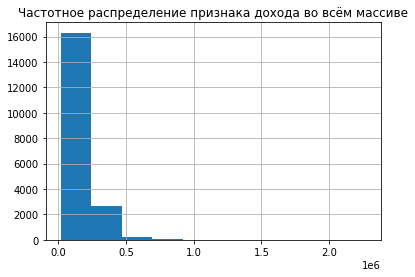

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Частотное распределение признака дохода во всём массиве')
data['total_income'].hist()
plt.show()

In [14]:
data['total_income'] = data['total_income'].fillna(data.groupby('income_type')['total_income'].transform('median'))
data['total_income'].isna().sum()

0

В переменной цели кредита пропущенных данных нет.

In [15]:
print(data['purpose'].isna().sum())

0


Посмотрим на переменную пола.

In [16]:
data['gender'].value_counts()

F      14154
M       7247
XNA        1
Name: gender, dtype: int64

Посмотрим, кто имеет значение XNA вручную.

In [17]:
data.loc[data['gender'] == "XNA"]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10646,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Этот человек 24 лет в браке без детей, текущий или незакончивший вуз студент, бравший кредит на жильё и возвращающий его в срок. Данных для установления пола недостаточно. Удалим этот случай, т.к. он не входит в группу людей, характеристики которых нам в будущем нужно предсказать.

In [18]:
data['gender'] = data[data['gender'] != "XNA"]['gender']
data.dropna(subset = ['gender'])
data.reset_index(drop=True)
data['gender'].value_counts()

F    14154
M     7247
Name: gender, dtype: int64

Далее переменная трудового стажа. Она вещественная, поэтому посчитаем описательные статистики и заодно посмотрим на них визуально.

count     19240.000000
mean      63159.820777
std      140928.943329
min      -18388.949901
25%       -2747.235601
50%       -1203.934202
75%        -289.740178
max      401755.400475
Name: days_employed, dtype: float64
2162


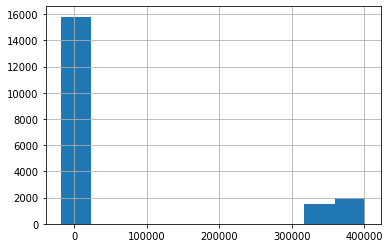

In [19]:
print(data['days_employed'].describe())
print(data['days_employed'].isnull().sum())
data['days_employed'].hist()

Набор данных странный. Посмотрим на левый отрезок поближе.

-1630.4435908090563
-24.14163324048118


15809

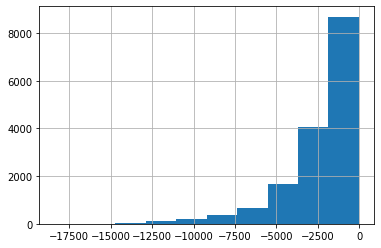

In [20]:
data[data['days_employed'] <= 200000]['days_employed'].hist()
print(data[data['days_employed'] <= 200000]['days_employed'].median())
print(data[data['days_employed'] <= 200000]['days_employed'].max())

data[data['days_employed'] <= 200000]['days_employed'].count()

Все значения слева, а это 3/4 массива, имеют отрицательное значение. Данные в разбросе от 0 до 50 лет c медианой в районе 4,5 лет, что похоже на правду. Можно предположить, что это разница от даты обращения до даты трудоустройства, поэтому данному объему данных можно просто поменять знак. Сделаем это позже, а пока посмотрим на правую часть данных на графике.

365286.6226495429


3431

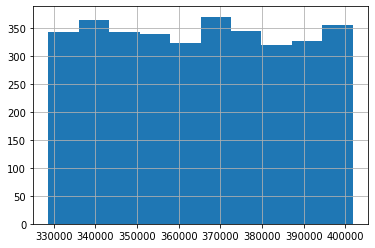

In [21]:
data[data['days_employed'] >= 200000]['days_employed'].hist()
print(data[data['days_employed'] >= 200000]['days_employed'].median())
data[data['days_employed'] >= 200000]['days_employed'].count()

Данные разбросаны в пределах от 330 тыс. до 400 тыс. и их более 10% массива, не удалить. Причём распределены они почти равномерно: количество пенсионеров с минимальным и максимальным значением в указанных рамках примерно равно. В отличие от трудового стажа, где количество людей по мере роста трудового стажа убывает на каждом интервале. Мы пропустим этап исследований и сразу покажем, что мы установили, что это всё пенсионеры и безработные:

In [22]:
data[data['days_employed'] >= 200000]['income_type'].value_counts()

пенсионер      3429
безработный       2
Name: income_type, dtype: int64

Возраст пенсионеров варьируется больше, чем данные по трудовому стажу, и под количество лет, оставшееся до 75 лет, данные тоже не подходят. Предположим, что в столбец трудового стажа для пенсионеров и безработных внесены какие-то другие данные - дополнительный доход к пенсии или сумма кредита. С точки зрения трудового стажа эти категории граждат имеют 0 стажа и для них нужна будет другая модель кредитного скорринга, сообщим об этом заказчику (иначе средние значения трудового стажа по всему массиву будут смещены к 0).

А пока заменим данный тип данных на 0, и только эти случаи в базе будут иметь 0 трудового стажа (ранее мы видели, что минимальный трудовой стаж - 24 дня), что даст нам возможность в будущем поменять данные, как только мы получим новые вводные от заказчика. Также заменим отрицательные значения, как планировали ранее.

Пропуски заполним медианами трудового стажа в соответствии с возрастом, т.к. эти переменные явно связаны.

0

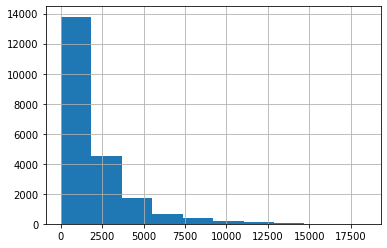

In [23]:
data['days_employed'].where(~(data.days_employed > 300000), other=0, inplace=True)
data.loc[data['days_employed'] < 0,'days_employed'] = data.loc[data['days_employed'] < 0]['days_employed'] * (-1)
data['days_employed'] = data['days_employed'].fillna(data.groupby('dob_years')['days_employed'].transform('median'))
data['days_employed'].hist()
data['days_employed'].isna().sum()

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21402 entries, 0 to 21401
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21401 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  float64
 11  purpose           21402 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Пропусков в данных не осталось, однако есть ещё переменные, которых мы не касались. Это образование. Посмотрим сводную таблицу по двум переменным образования:

In [25]:
data_pivot_education = data.pivot_table(index=['education'], columns='education_id', values='debt', aggfunc='count')
print(data_pivot_education)
data_pivot_education.sum().sum()

education_id              0        1      2      3    4
education                                              
ВЫСШЕЕ                271.0      NaN    NaN    NaN  NaN
Высшее                268.0      NaN    NaN    NaN  NaN
НАЧАЛЬНОЕ               NaN      NaN    NaN   17.0  NaN
НЕОКОНЧЕННОЕ ВЫСШЕЕ     NaN      NaN   29.0    NaN  NaN
Начальное               NaN      NaN    NaN   15.0  NaN
Неоконченное высшее     NaN      NaN   47.0    NaN  NaN
СРЕДНЕЕ                 NaN    766.0    NaN    NaN  NaN
Среднее                 NaN    703.0    NaN    NaN  NaN
УЧЕНАЯ СТЕПЕНЬ          NaN      NaN    NaN    NaN  1.0
Ученая степень          NaN      NaN    NaN    NaN  1.0
высшее               4698.0      NaN    NaN    NaN  NaN
начальное               NaN      NaN    NaN  250.0  NaN
неоконченное высшее     NaN      NaN  665.0    NaN  NaN
среднее                 NaN  13667.0    NaN    NaN  NaN
ученая степень          NaN      NaN    NaN    NaN  4.0


21402.0

С распределением типов образования по категориям всё в порядке. А вот написание видов образования отличается, исправим это, чтобы количество категорий образования было корректным.

In [26]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15136
высшее                  5237
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

Посмотрим на характер переменной возраста.

In [27]:
data['dob_years'].describe()

count    21402.000000
mean        43.300206
std         12.579055
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

Среднее близко к медиане, максимальный возраст соответствует правилам выдачи кредитов (https://www.sravni.ru/enciklopediya/info/mozhet-li-pensioner-vzjat-kredit/)
Однако в массиве не должно быть 0. Посмотрим, сколько их и кто они, например, по типу занятости.

In [28]:
print(data.loc[data['dob_years'] == 0]['income_type'].value_counts())
data.loc[data['dob_years'] == 0]['income_type'].count()

сотрудник      54
пенсионер      20
компаньон      20
госслужащий     6
Name: income_type, dtype: int64


100

Связи этих значений "0" ни с типом занятости, ни с другими столбцами таблицы не найдено. Можно предположить, что данные пропущены условно случайно. В поисках способа замены данных найдена связь между возрастом и типом образования:

In [29]:
data.groupby('education_id')['dob_years'].median().sort_values()

education_id
2    31.0
0    39.0
1    44.0
3    46.5
4    51.5
Name: dob_years, dtype: float64

Заменим "0" по возрасту медианными возрастами групп по уровню образования:

In [30]:
data['dob_years'] = data[data['dob_years'] != 0]['dob_years']
data.dropna(subset = ['dob_years'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['dob_years'] = data['dob_years'].fillna(data.groupby('education_id')['dob_years'].transform('median'))
data['dob_years'].describe()

count    21302.000000
mean        43.503474
std         12.252843
min         19.000000
25%         33.000000
50%         43.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

**Вывод**

Мы получили 21 301 кейс для анализа. Во всех переменных отсутствуют пропуски, что делает базу максимально полной для работы с гипотезами. Данные были удалены только по столбцу количества детей, т.к. восстановление этих данных по другим переменным будет иметь случайный характер.

### Замена типа данных

Посмотрим ещё раз на типы данных.

In [31]:
data.dtypes

children              int64
days_employed       float64
dob_years           float64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Предположим, что доход имеет дробную часть ввиду расчётного характера показателя. Для данной базы данных доход может рассчитываться как среднедушевой доход члена семьи как здесь https://www.gosuslugi.ru/help/faq/roditeli_i_deti/100525
Однако чтобы сократить объем используемой памяти сделаем и доход, и количество отработанных дней целым числом.

Также в процессе восстановления данных по возрасту года получили дробную часть, вернём эту переменную к целым значениям.
Воспользуемся наиболее простым методом, который подойдёт для dataframe и предварительно округлим числа, чтобы не потерять точность данных.

In [32]:
data.round({'days_employed': 0, 'total_income': 0, 'dob_years': 0})
data.astype({'days_employed': 'int8', 'total_income': 'int8', 'dob_years': 'int8'}).dtypes

children             int64
days_employed         int8
dob_years             int8
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income          int8
purpose             object
dtype: object

**Вывод**

Данные по трудовому стажу заменены на целые числа. Типы прочих данных соответствуют их сути.

### Обработка дубликатов

Ищем дубликаты подходящим для этого методом и суммируем результат.

In [33]:
data.duplicated().sum()

72

Это небольшой объем записей, посмотрим на него "вживую".

In [34]:
data['duplicated'] = data.duplicated()
data.loc[data['duplicated'] == True]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,duplicated
2823,0,1847.778632,41.0,среднее,1,женат / замужем,0,F,сотрудник,0,142587.588976,покупка жилья для семьи,True
3260,0,0.000000,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,118480.837408,сыграть свадьбу,True
4142,1,1588.471257,34.0,высшее,0,гражданский брак,1,F,сотрудник,0,142587.588976,свадьба,True
4808,0,0.000000,60.0,среднее,1,гражданский брак,1,F,пенсионер,0,118480.837408,свадьба,True
5506,0,0.000000,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,118480.837408,сыграть свадьбу,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20488,0,0.000000,64.0,среднее,1,женат / замужем,0,F,пенсионер,0,118480.837408,дополнительное образование,True
20816,0,0.000000,60.0,среднее,1,женат / замужем,0,F,пенсионер,0,118480.837408,заняться образованием,True
20916,0,1999.975513,47.0,среднее,1,женат / замужем,0,F,сотрудник,0,142587.588976,ремонт жилью,True
21063,1,1425.322890,30.0,высшее,0,женат / замужем,0,F,сотрудник,0,142587.588976,покупка коммерческой недвижимости,True


В используемой базе данных есть крайне вариативные переменные цели кредита, записанной текстом и дохода с точностью до 6 знака после запятой. Это снижает вероятность наличия в базе людей с настолько совпадающими данными, дублирование данных могло возникнуть при попытке повторного ввода, если он происходит вручную.

Удалим доубликаты соответствующим методом, сбросив индексы, чтобы нумерация кейсов была актуальной.

In [35]:
data = data.loc[:, 'children': 'purpose']
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21230 entries, 0 to 21229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21230 non-null  int64  
 1   days_employed     21230 non-null  float64
 2   dob_years         21230 non-null  float64
 3   education         21230 non-null  object 
 4   education_id      21230 non-null  int64  
 5   family_status     21230 non-null  object 
 6   family_status_id  21230 non-null  int64  
 7   gender            21229 non-null  object 
 8   income_type       21230 non-null  object 
 9   debt              21230 non-null  int64  
 10  total_income      21230 non-null  float64
 11  purpose           21230 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 1.9+ MB


**Вывод**

Мы удалили 72 дублирующихся записи в таблице. Общее количество случаев для анализа сократилось с 21 301 до 21 229.

### Категоризация текстовой переменной с помощью лемматизации

У нас есть столбец, где в свободной форме прописана цель кредита. Т.к. нам нужно установить зависимость невозврата кредита от цели, нам нужно категоризировать цель кредита. А для этого нужно лемматизировать весь текст в столбце цели во всей таблице. Но этой займёт слишком много ресурсов. Посмотрим, так ли отличаются значения цели кредита.

In [36]:
len(data['purpose'].value_counts())

38

У нас всего 38 типов целей, лемматизируем этот список.

In [ ]:
Counter(Mystem().lemmatize(str(data['purpose'].to_list())))

```
Counter({"['": 1,
         'покупка': 5838,
         ' ': 33244,
         'жилье': 4413,
         "', '": 21229,
         'приобретение': 457,
         'автомобиль': 4258,
         'дополнительный': 895,
         'образование': 3970,
         'сыграть': 755,
         'свадьба': 2299,
         'операция': 2576,
         'с': 2886,
         'на': 2196,
         'проведение': 759,
         'для': 1283,
         'семья': 636,
         'недвижимость': 6290,
         'коммерческий': 1298,
         'жилой': 1216,
         'строительство': 1862,
         'собственный': 626,
         'подержать': 838,
         'свой': 2212,
         'со': 623,
         'заниматься': 900,
         'сделка': 933,
         'получение': 1304,
         'высокий': 1359,
         'подержанный': 112,
         'профильный': 431,
         'сдача': 647,
         'ремонт': 602,
         "']\n": 1})
```

Если отбросить все глаголы и вспомогательные части речи, соединить близкие по смыслу цели, то мы получим всего 6 вариантов, для чего люди обращались за кредитом: 
1. Для покупки недвижимости, сюда дже включим ремонт, т.к. его стоимость также сопоставима с покупкой жилья. Кроме того, ремонт - последний в списке посчёта лемм, эту категорию нужно объединить с близкой по смыслу.
2. Операции с коммерческой недвижимостью отнесём в отдельную категорию, сделав исключение для данной группы. Очень вероятно, что эти кредит на бизнес-цели, под коммерческой недвижимостью понимаются офисы, торговые помещения, а это имеет мало отношения к квартирам, дачам и ремонту жилья.
3. Строительство жилья. Соответствующая лемма расположена достаточно высоко в рейтинге результатов контент-анализа, значит она достаточно крупная, чтобы отделить её от недвижимости в целом.
4. Автокредит.
5. Для проведения свадьбы.
6. Для получения образования.

**Вывод**

Мы определили типы целей, их оказалось всего 6. Теперь нам будет проще понять, возращают ли кредит в срок в зависимости от цели.

### Категоризация данных

Для подтверждения гипотез нам нужно добавить несколько переменных:
1. Столбец о количестве детей нужно преобразовать в столбец о наличии детей.
2. Столбец об уровне дохода нужно разделить на несколько категорий.
3. Столбец о целях кредита нужно сократить до 5 указанных выше.
4. Столбец о семейном положении нужно сократить до 2 позиций. С точки зрения кредита имеет значение лишь количество членов домохозяйства, поэтому сделаем из нее бинарную переменную, где 1 - есть сожитель, 0 - вероятнее всего нет.

Создаём новый столбец о количестве детей:

In [37]:
data['children_bool'] = data['children'].replace([2, 3, 4, 5], 1)

Столбец об уровне дохода делим на 4 равные группы. Для этого подойдёт разделение переменной по квартилям. Посмотрим ещё раз на данные дохода после предварительной обработки.

In [38]:
data['total_income'].describe()

count    2.123000e+04
mean     1.653910e+05
std      9.842562e+04
min      2.066726e+04
25%      1.075506e+05
50%      1.425876e+05
75%      1.958209e+05
max      2.265604e+06
Name: total_income, dtype: float64

Категоризируем его, создав новый столбец с помощью функции:

In [39]:
def income_group(income):
    if income <= 1.075460e+05:
        return 'низкий'
    if income <= 1.425880e+05:
        return 'средне низкий'
    if income <= 1.958190e+05:
        return 'средне высокий'
    return 'высокий'
data['income_group'] = data['total_income'].apply(income_group)

Столбец о целях кредита преобразуем в сокращенные категории кредита с помощью словаря категорий.

In [40]:
purpose_map = {
    'свадьба': 'свадьба',
    'на проведение свадьбы': 'свадьба',
    'сыграть свадьбу': 'свадьба',

    'покупка жилья для сдачи': 'покупка жилой недвижимости',
    'операции с жильем': 'покупка жилой недвижимости',
    'операции с недвижимостью': 'покупка жилой недвижимости',
    'жилье': 'покупка жилой недвижимости',
    'покупка жилья': 'покупка жилой недвижимости',
    'покупка жилья для семьи': 'покупка жилой недвижимости',
    'недвижимость': 'покупка жилой недвижимости',
    'операции со своей недвижимостью': 'покупка жилой недвижимости',
    'покупка своего жилья': 'покупка жилой недвижимости',
    'покупка недвижимости': 'покупка жилой недвижимости',
    'ремонт жилью': 'покупка жилой недвижимости',
    'покупка жилой недвижимости': 'покупка жилой недвижимости',
    
    'строительство собственной недвижимости': 'строительство',
    'строительство жилой недвижимости': 'строительство',
    'строительство недвижимости': 'строительство',
    
    'покупка коммерческой недвижимости': 'коммерческая недвижимость',
    'операции с коммерческой недвижимостью': 'коммерческая недвижимость',
    
    'на покупку своего автомобиля': 'авто',
    'автомобиль': 'авто',
    'сделка с подержанным автомобилем': 'авто',
    'автомобили': 'авто',
    'свой автомобиль': 'авто',
    'на покупку подержанного автомобиля': 'авто',
    'на покупку автомобиля': 'авто',
    'приобретение автомобиля': 'авто',
    'сделка с автомобилем': 'авто',
   
    'высшее образование': 'образование',
    'дополнительное образование': 'образование',
    'заняться высшим образованием': 'образование',
    'получение дополнительного образования': 'образование',
    'образование': 'образование',
    'получение образования': 'образование',
    'профильное образование': 'образование',
    'получение высшего образования': 'образование',
    'заняться образованием': 'образование'}
data['purpose_id'] = data['purpose'].map(purpose_map)

Создаём сокращённый столбец данных о наличии семьи:

In [41]:
data['purpose_bool'] = data['purpose_id'].replace(['образование', 'авто', 'свадьба', 'покупка жилой недвижимости', 'строительство', 'коммерческая недвижимость'], [6,7,8,9,10,11])
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_bool,income_group,purpose_id,purpose_bool
3130,0,0.000000,71.0,среднее,1,женат / замужем,0,F,пенсионер,0,114510.462596,строительство собственной недвижимости,0,средне низкий,строительство,10
17220,1,527.447471,41.0,высшее,0,женат / замужем,0,M,компаньон,1,176231.690646,сделка с автомобилем,1,средне высокий,авто,7
13069,0,1990.589348,46.0,среднее,1,женат / замужем,0,F,компаньон,0,172517.418907,покупка своего жилья,0,средне высокий,покупка жилой недвижимости,9
20579,0,917.657331,28.0,среднее,1,женат / замужем,0,F,компаньон,1,75741.350851,ремонт жилью,0,низкий,покупка жилой недвижимости,9
12779,1,1239.301867,48.0,среднее,1,женат / замужем,0,M,сотрудник,0,123471.121190,автомобили,1,средне низкий,авто,7


In [42]:
data['family_bool'] = data['family_status_id'].replace([0, 1, 2, 3, 4], [1, 1, 0, 0, 0])

Проверяем категоризацию на первых строках массива:

In [43]:
data.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_bool,income_group,purpose_id,purpose_bool,family_bool
0,1,8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,1,высокий,покупка жилой недвижимости,9,1
1,1,4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,1,средне низкий,авто,7,1
2,0,5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,0,средне высокий,покупка жилой недвижимости,9,1
3,3,4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,1,высокий,образование,6,1
4,0,0.000000,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,0,средне высокий,свадьба,8,1
5,0,926.185831,27.0,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,0,высокий,покупка жилой недвижимости,9,1
6,0,2879.202052,43.0,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,0,высокий,покупка жилой недвижимости,9,1
7,0,152.779569,50.0,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,0,средне низкий,образование,6,1
8,2,6929.865299,35.0,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,1,низкий,свадьба,8,1
9,0,2188.756445,41.0,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,0,средне высокий,покупка жилой недвижимости,9,1


**Вывод**

Все данные распределяются по новым категориям верно.

## 3. Ответы на ключевые вопросы заказчика

Покажем зависимость между независимыми переменными наличия детей, семейным положением, уровнем дохода и целями кредита и зависимой переменной возврата кредита в срок. Можно сделать это с помощью сводных таблиц, например для наличия детей, так:

In [44]:
data.pivot_table(index=['children_bool'], columns='debt', values='education', aggfunc='count', margins=True)

debt,0,1,All
children_bool,,,
0,12963,1058,14021
1,6543,666,7209
All,19506,1724,21230


Это не очень удобно, т.к. размер групп большой, а количество возвращающих кредит вовремя и имевших задолжености существенно отличается. Нужны процентные распределения. Более рациональным в данном случае будет построение перекрёстной таблицы, где данные будут нормализованы относительно столбцов.

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [45]:
print('Вероятность бездетного клиента стать должником {:.0%}'
      .format(data.loc[data['children_bool'] == 0, 'debt'].sum()/data.loc[data['children_bool'] == 0, 'debt'].count()))
print('Вероятность клиента с деньми стать должником {:.3f}'
      .format(data.loc[data['children_bool'] == 1, 'debt'].sum()/data.loc[data['children_bool'] == 1, 'debt'].count()))
pd.crosstab(
    data['children_bool'], data['debt'],
    values=data['debt'],
    aggfunc='count',
    normalize='columns').applymap(lambda x: "{0:.0f}%".format(100*x))

Вероятность бездетного клиента стать должником 8%
Вероятность клиента с деньми стать должником 0.092


debt,0,1
children_bool,,
0,66%,61%
1,34%,39%


**Вывод**

Небольшая разница в распределении есть. Бездетные заёмщики чаще отдавали кредиты в срок. Возможно, это связано с возрастом или с более высокими доходами бездетных потребителей (если доход вычисляется как среднедушевой доход в семье).

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
print('Вероятность одинокого клиента стать должником {:.3f}'
      .format(data.loc[data['family_bool'] == 0, 'debt']
              .sum()/data.loc[data['family_bool'] == 0, 'debt']
              .count()))
print('Вероятность семейного клиента стать должником {:.3f}'
      .format(data.loc[data['family_bool'] == 1, 'debt']
              .sum()/data.loc[data['family_bool'] == 1, 'debt']
              .count()))

pd.crosstab(
    data['family_bool'], data['debt'],
    values=data['debt'],
    aggfunc='count',
    normalize='columns').applymap(lambda x: "{0:.0f}%".format(100*x))

Вероятность одинокого клиента стать должником 0.085
Вероятность семейного клиента стать должником 0.080


debt,0,1
family_bool,,
0,23%,24%
1,77%,76%


**Вывод**

Здесь разница ещё менее существенна. И семейные, и одинокие одинаково часто отдают кредиты в срок или попадают в должники.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [47]:
print('Вероятность клиента с низким доходом стать должником {:.3f}'
      .format(data.loc[data['income_group'] == 'низкий', 'debt']
              .sum()/data.loc[data['income_group'] == 'низкий', 'debt']
              .count()))
print('Вероятность клиента со средне низким доходом стать должником {:.3f}'
      .format(data.loc[data['income_group'] == 'средне низкий', 'debt']
              .sum()/data.loc[data['income_group'] == 'средне низкий', 'debt']
              .count()))
print('Вероятность клиента со средне высоким доходом стать должником {:.3f}'
      .format(data.loc[data['income_group'] == 'средне высокий', 'debt']
              .sum()/data.loc[data['income_group'] == 'средне высокий', 'debt']
              .count()))
print('Вероятность клиента с высоким доходом стать должником {:.3f}'
      .format(data.loc[data['income_group'] == 'высокий', 'debt']
              .sum()/data.loc[data['income_group'] == 'высокий', 'debt']
              .count()))

pd.crosstab(
    data['income_group'], data['debt'],
    values=data['debt'],
    aggfunc='count',
    normalize='columns').applymap(lambda x: "{0:.0f}%".format(100*x))

Вероятность клиента с низким доходом стать должником 0.080
Вероятность клиента со средне низким доходом стать должником 0.088
Вероятность клиента со средне высоким доходом стать должником 0.085
Вероятность клиента с высоким доходом стать должником 0.072


debt,0,1
income_group,,
высокий,25%,22%
низкий,25%,25%
средне высокий,24%,26%
средне низкий,25%,28%


**Вывод**

Разница в группах менее драматична, чем предполагалось. Чем выше доход, тем более ответственно потребители ведут себя с кредитами, т.к. вероятно, это не является для них существенной проблемой. Однако связь не является однонаправленной. Среди группы с низким доходом одинаковая доля тех, кто отдаёт кредиты в срок и кто этого не делает. Наибольшая разница - в группе средне низкого дохода. Возможно, потребители с низким доходом более ответственно подходят к планированию расходов и берут кредиты только в крайнем случае.

- Как разные цели кредита влияют на его возврат в срок?

In [48]:
print('Вероятность покупателя авто стать должником {:.3f}'
      .format(data.loc[data['purpose_id'] == 'авто', 'debt']
              .sum()/data.loc[data['purpose_id'] == 'авто', 'debt']
              .count()))
print('Вероятность покупателя коммерческой недвижимости стать должником {:.3f}'
      .format(data.loc[data['purpose_id'] == 'коммерческая недвижимость', 'debt']
              .sum()/data.loc[data['purpose_id'] == 'коммерческая недвижимость', 'debt']
              .count()))
print('Вероятность получающего образование стать должником {:.3f}'
      .format(data.loc[data['purpose_id'] == 'образование', 'debt']
              .sum()/data.loc[data['purpose_id'] == 'образование', 'debt']
              .count()))
print('Вероятность покупателя недвижимости стать должником {:.3f}'
      .format(data.loc[data['purpose_id'] == 'покупка жилой недвижимости', 'debt']
              .sum()/data.loc[data['purpose_id'] == 'покупка жилой недвижимости', 'debt']
              .count()))
print('Вероятность планирующего свадьбу стать должником {:.3f}'
      .format(data.loc[data['purpose_id'] == 'свадьба', 'debt']
              .sum()/data.loc[data['purpose_id'] == 'свадьба', 'debt']
              .count()))
print('Вероятность строящего дом стать должником {:.3f}'
      .format(data.loc[data['purpose_id'] == 'строительство', 'debt']
              .sum()/data.loc[data['purpose_id'] == 'строительство', 'debt']
              .count()))

pd.crosstab(
    data['purpose_id'], data['debt'],
    values=data['debt'],
    aggfunc='count',
    normalize='columns').applymap(lambda x: "{0:.0f}%".format(100*x))

Вероятность покупателя авто стать должником 0.093
Вероятность покупателя коммерческой недвижимости стать должником 0.076
Вероятность получающего образование стать должником 0.093
Вероятность покупателя недвижимости стать должником 0.071
Вероятность планирующего свадьбу стать должником 0.079
Вероятность строящего дом стать должником 0.077


debt,0,1
purpose_id,,
авто,20%,23%
коммерческая недвижимость,6%,6%
образование,18%,21%
покупка жилой недвижимости,36%,31%
свадьба,11%,10%
строительство,9%,8%


**Вывод**

А вот разница в целях наиболее существенна с учётом достаточно большого количества анализируемых групп по целям. Здесь более благонадёжными заёмщиками являются те, кому необходимо жильё. Причём покупка делает больший шанс на возврат его в срок, чем строительство. Образование же и автокредит - не очень удачные цели кредита с точки зрения возврата банком своих инвестиций. Такие кредиты чаще подвергаются просрочкам, возможно, ввиду самого характера приобретаемого блага.

## 4. Общий вывод

Мы подготовили данные для дальнейшего анализа и сделали предварительную проверку гипотез для дальнейшего исследования.
- Зависимость между наличием детей и возвратом кредита в срок?" обнаружена, необходимо дальнейшее исследование;
- Зависимость между семейным положением и возвратом кредита в срок?" не обнаружена;
- Зависимость между уровнем дохода и возвратом кредита в срок?" обнаружена;
- Зависимость между целью кредита и возвратом кредита в срок?" обнаружена.

При передаче данных для последующей обработки необходимо предоставить комментарий об удалённых случаях:
- Из массива удалено 123 случая в связи с невосстанавливаемыми ошибками переменной количества детей;
- Из массива удален 1 случай в связи с невосстанавливаемой ошибкой переменной пола;
- Из массива удалено 72 дубликата после вышеописанных действий;

Преобразования переменных:
- Значения переменной образования приведены к единообразию;
- Значения переменной трудового стажа были отрицательными, заменены на положительные того же значения. Трудовой стаж пенсионеров и безработных варьировался в пределах от 330 тыс. до 300 тыс. единиц. Ввиду невозможности установления значения данных цифр они заменены на 0. В дальнейшем переменную трудового стажа необходимо использовать, исключая данные группы;
- Значения возраста, равные "0", признаны ошибочными и заменены на медианные возрасты групп потребителей по образованию;
- Пропуски в переменной дохода заполнены на основании медианных доходов потребителей по типам занятости;
- В базу добавлены новые переменные:
    * children_bool принимает значение "1" при наличии детей
    * income_group - группа дохода, выделенная на основании квартилей
    * purpose_id - категоризированные цели кредита
    * family_bool принимает значение "1" при наличии семьи